In [1]:
from torchvision import models
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import cv2
import numpy as np 

In [2]:
def decode_segmap(image, source, nc=21):
    label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
  
    #每个像素对应的类别赋予相应的颜色
    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]
  
    #这个就是语义分割的彩色图
    rgb = np.stack([r, g, b], axis=2)
    plt.imshow(rgb)
    #plt.axis('off')
    plt.show()
 
    foreground = cv2.imread(source)
 
    foreground = cv2.cvtColor(foreground, cv2.COLOR_BGR2RGB)
    foreground = cv2.resize(foreground, (r.shape[1], r.shape[0]))
 
    #这里使用一张全白的图像作为替换的背景
    background = 255 * np.ones_like(rgb).astype(np.uint8)
 
    foreground = foreground.astype(float)
    background = background.astype(float)
 
    #背景的值为0，这里以0为阈值由分割图得到mask，分离出背景
    #在二值化之前需要先将分割图转化成灰度图，否则thresh分别作用于每个通道
    gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
    th, binary= cv2.threshold(np.array(gray), 0, 255, cv2.THRESH_BINARY)
    #由于边缘很锐利，所以做一个模糊平滑边缘，这样在过渡的地方看起来自然一些
    mask = cv2.GaussianBlur(binary, (7, 7), 0)
    #将mask转换成3通道
    alpha = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    alpha = alpha.astype(float)/255
    plt.imshow(alpha)
    #plt.axis('off')
    plt.show()
 
    #alpha混合
    foreground = cv2.multiply(alpha, foreground)
 
    background = cv2.multiply(1.0 - alpha, background)
 
    outImage = cv2.add(foreground, background)
 
    return outImage/255

In [3]:

def segment(net, path, show_orig=True):
    img = Image.open(path)
    if show_orig:
        plt.imshow(img)
        #plt.axis('off')
        plt.show()
    trf = T.Compose([T.ToTensor(),
           T.Normalize(mean = [0.485, 0.456, 0.406],
                 std = [0.229, 0.224, 0.225])])
    inp = trf(img).unsqueeze(0)
    out = net(inp)['out']
    om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
    rgb = decode_segmap(om, path)
  
    #rgb = cv2.cvtColor(np.float32(rgb), cv2.COLOR_RGB2BGR)
    plt.imshow(rgb)
    #plt.axis('off')
    plt.show()

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to C:\Users\WTW-NP/.cache\torch\checkpoints\deeplabv3_resnet101_coco-586e9e4e.pth
100%|████████████████████████████████████████████████████████████████| 244545539/244545539 [08:18<00:00, 490309.98it/s]


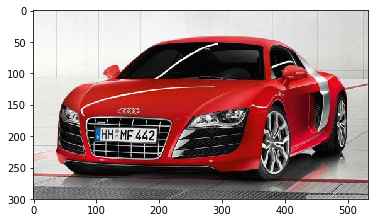

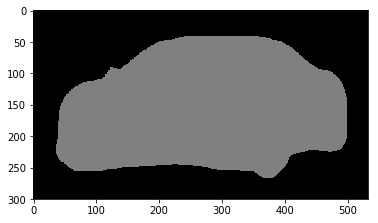

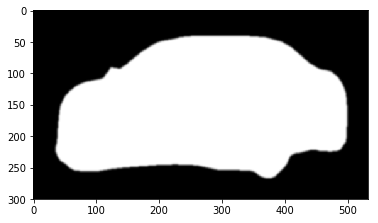

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


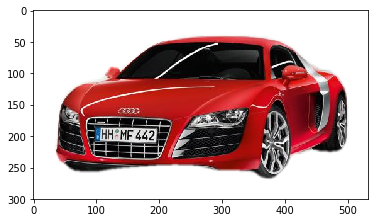

In [4]:
dlab = models.segmentation.deeplabv3_resnet101(pretrained=1).eval()
segment(dlab, './car.jpg')

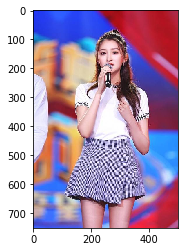

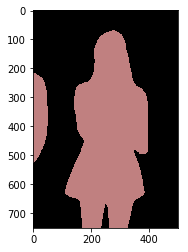

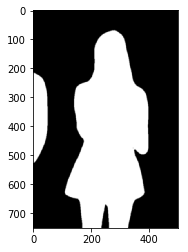

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


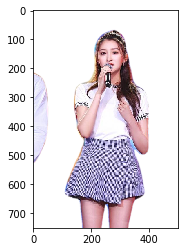

In [7]:
segment(dlab, './guanxiaotong1.jpg')